In [1]:
import torch
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
import time
import numpy as np
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #use gpu to run

### 1. Projector

In [3]:
class MatrixXRayProjector:
    def __init__(self, volume_shape, image_shape, pixel_spacing, SOD, SID):
        """
        Matrix-based implementation of the projection operator Π_k(X) = P·vec(X)
        
        Args:
            volume_shape: (m,n,p) or (n,n,n) - 3D volume dimensions
            image_shape: (h,w) - 2D detector dimensions
            pixel_spacing: (dx,dy) - Pixel spacing in mm 
            SOD: Source-to-Isocenter Distance in mm 
            SID: Source-to-Detector Distance in mm 
        """
        self.volume_shape = volume_shape
        self.image_shape = image_shape
        self.pixel_spacing = torch.tensor(pixel_spacing, device=device)
        self.SOD = SOD
        self.SID = SID
        
        # Precompute all possible voxel coordinates
        z, y, x = torch.meshgrid(
            torch.arange(volume_shape[0], device=device),
            torch.arange(volume_shape[1], device=device),
            torch.arange(volume_shape[2], device=device),
            indexing='ij'
        )
        self.voxel_coords = torch.stack((x, y, z), dim=-1).float() - torch.tensor(volume_shape, device=device)//2
        
    def get_rotation_matrix(self, alpha, beta):
        """Same rotation matrix as before"""
        cos_a, sin_a = math.cos(alpha), math.sin(alpha)
        cos_b, sin_b = math.cos(beta), math.sin(beta)
    
        return torch.tensor([
            [cos_b,         sin_b*sin_a,      sin_b*cos_a],
            [0,             cos_a,            -sin_a],
            [-sin_b,        cos_b*sin_a,      cos_b*cos_a]
        ], device=device)
    
    def build_projection_matrix(self, alpha, beta):
        """
        Build the sparse projection matrix P for given angles
        
        Returns:
            P: Sparse matrix of shape (h*w, m*n*p) where P[i*w+j, :] corresponds to pixel (i,j)
        """
        h, w = self.image_shape
        m, n, p = self.volume_shape
        total_pixels = h * w
        total_voxels = m * n * p
        
        # Initialize lists for sparse matrix construction
        row_indices = []
        col_indices = []
        
        # Apply rotation to all voxels
        R = self.get_rotation_matrix(alpha, beta)
        rotated_coords = torch.matmul(self.voxel_coords, R.T)
        
        # Perspective projection
        proj_coords = rotated_coords.clone()
        proj_coords[..., 2] += self.SOD
        
        # Only consider points in front of the detector
        valid_mask = proj_coords[..., 2] > 0
        valid_voxels = torch.nonzero(valid_mask)
        
        # Project valid voxels
        det_coords = (proj_coords[valid_mask][..., :2] / 
                     proj_coords[valid_mask][..., 2].unsqueeze(-1)) * self.SID
        
        # Convert to pixel coordinates
        pixel_coords = det_coords / self.pixel_spacing + torch.tensor([w/2, h/2], device=device)
        pixel_coords = pixel_coords.round().long()
        
        # Filter valid pixels
        pixel_valid = (
            (pixel_coords[:, 0] >= 0) & 
            (pixel_coords[:, 0] < w) & 
            (pixel_coords[:, 1] >= 0) & 
            (pixel_coords[:, 1] < h))
        
        valid_pixel_coords = pixel_coords[pixel_valid]
        valid_voxel_indices = valid_voxels[pixel_valid]
        
        # Convert voxel indices to linear indices
        voxel_linear_indices = (
            valid_voxel_indices[:, 0] * n * p + 
            valid_voxel_indices[:, 1] * p + 
            valid_voxel_indices[:, 2])
        
        # Convert pixel coordinates to linear indices
        pixel_linear_indices = (
            valid_pixel_coords[:, 1] * w + 
            valid_pixel_coords[:, 0])
        
        # Create sparse matrix
        indices = torch.stack([pixel_linear_indices, voxel_linear_indices], dim=0)
        values = torch.ones(len(pixel_linear_indices), device=device)
        
        P = torch.sparse_coo_tensor(
            indices, 
            values, 
            size=(total_pixels, total_voxels),
            device=device
        )
        
        return P
    
    def project_volume(self, X, alpha, beta):
        """
        Project using sparse matrix multiplication: Π_k(X) = P·vec(X)
        
        Args:
            X: Binary 3D volume tensor (m,n,p)
            alpha: Primary angle in radians
            beta: Secondary angle in radians
            
        Returns:
            Projected 2D binary image I_k (h,w)
        """
        # Build or get cached projection matrix
        P = self.build_projection_matrix(alpha, beta)
        
        # Vectorize input
        vec_X = X.flatten().float()
        
        # Sparse matrix multiplication
        proj_vec = torch.sparse.mm(P, vec_X.unsqueeze(-1)).squeeze()
        
        # Reshape and binarize
        proj_image = (proj_vec > 0).reshape(self.image_shape)
        
        return proj_image

### 2. Create test objects

In [4]:
def create_test_objects(volume_shape):
    """Create all 7 test 3D objects with consistent orientation"""
    volume = torch.zeros(volume_shape, device=device)
    center = torch.tensor(volume_shape) // 2
    
    # Create coordinate grids (Z,Y,X order for volume dimensions)
    z, y, x = torch.meshgrid(
        torch.arange(volume_shape[0], device=device),  # Z (depth)
        torch.arange(volume_shape[1], device=device),  # Y (vertical)
        torch.arange(volume_shape[2], device=device),  # X (horizontal)
        indexing='ij'
    )

    # 1. Cube (aligned with axes)
    cube_size = 20
    half = cube_size // 2
    cube = volume.clone()
    cube[center[0]-half:center[0]+half,
         center[1]-half:center[1]+half,
         center[2]-half:center[2]+half] = 1

    # 2. Cylinder (horizontal along X-axis)
    cylinder = volume.clone()
    radius = 10
    length = 30  # Length along X-axis
    mask = ((y - center[1])**2 + (z - center[0])**2 <= radius**2) & \
           (x >= center[2]-length//2) & (x <= center[2]+length//2)
    cylinder[mask] = 1

    # 3. Star (3D cross aligned with axes)
    star = volume.clone()
    cross_width = 5
    cross_length = 25
    # X-axis cross (horizontal)
    star[center[0]-cross_width//2:center[0]+cross_width//2,
         center[1]-cross_width//2:center[1]+cross_width//2,
         center[2]-cross_length//2:center[2]+cross_length//2] = 1
    # Y-axis cross (vertical)
    star[center[0]-cross_width//2:center[0]+cross_width//2,
         center[1]-cross_length//2:center[1]+cross_length//2,
         center[2]-cross_width//2:center[2]+cross_width//2] = 1
    # Z-axis cross (depth)
    star[center[0]-cross_length//2:center[0]+cross_length//2,
         center[1]-cross_width//2:center[1]+cross_width//2,
         center[2]-cross_width//2:center[2]+cross_width//2] = 1

    # 4. Sphere (perfectly symmetrical)
    sphere = volume.clone()
    sphere_radius = 15
    mask = ((x - center[2])**2 + (y - center[1])**2 + (z - center[0])**2) <= sphere_radius**2
    sphere[mask] = 1

    # 5. Torus (donut, horizontal orientation)
    torus = volume.clone()
    R = 15  # Major radius
    r = 5   # Minor radius
    mask = (torch.sqrt((y - center[1])**2 + (z - center[0])**2) - R)**2 + (x - center[2])**2 <= r**2
    torus[mask] = 1

    # 6. Pyramid (base on XY plane, peak along +Z)
    pyramid = volume.clone()
    base_size = 25
    height = 25
    for level in range(height):
        current_size = base_size * (1 - level/height)
        if current_size < 1:
            break
        half = int(current_size // 2)
        pyramid[center[0] + level,
                center[1]-half:center[1]+half,
                center[2]-half:center[2]+half] = 1

    # 7. Helix (horizontal along X-axis)
    helix = volume.clone()
    helix_radius = 10
    turns = 2
    pitch = 30  # Height per full turn
    for t in torch.linspace(0, turns*2*np.pi, 100):
        x_pos = int(center[2] + helix_radius * math.cos(t))  # X-coordinate
        y_pos = int(center[1] + helix_radius * math.sin(t))  # Y-coordinate
        z_pos = int(center[0] + pitch * t / (2*np.pi))      # Z-coordinate
        if all(0 <= p < s for p, s in zip((z_pos, y_pos, x_pos), volume_shape)):
            helix[z_pos, y_pos, x_pos] = 1
        # Add thickness
        for dz, dy, dx in [(0,0,0), (0,0,1), (0,1,0), (1,0,0)]:
            nz, ny, nx = z_pos+dz, y_pos+dy, x_pos+dx
            if all(0 <= p < s for p, s in zip((nz, ny, nx), volume_shape)):
                helix[nz, ny, nx] = 1

    return {
        'Cube': cube,
        'Cylinder': cylinder,
        'Star': star,
        'Sphere': sphere,
        'Torus': torus,
        'Pyramid': pyramid,
        'Helix': helix
    }


Visualizing Cube...


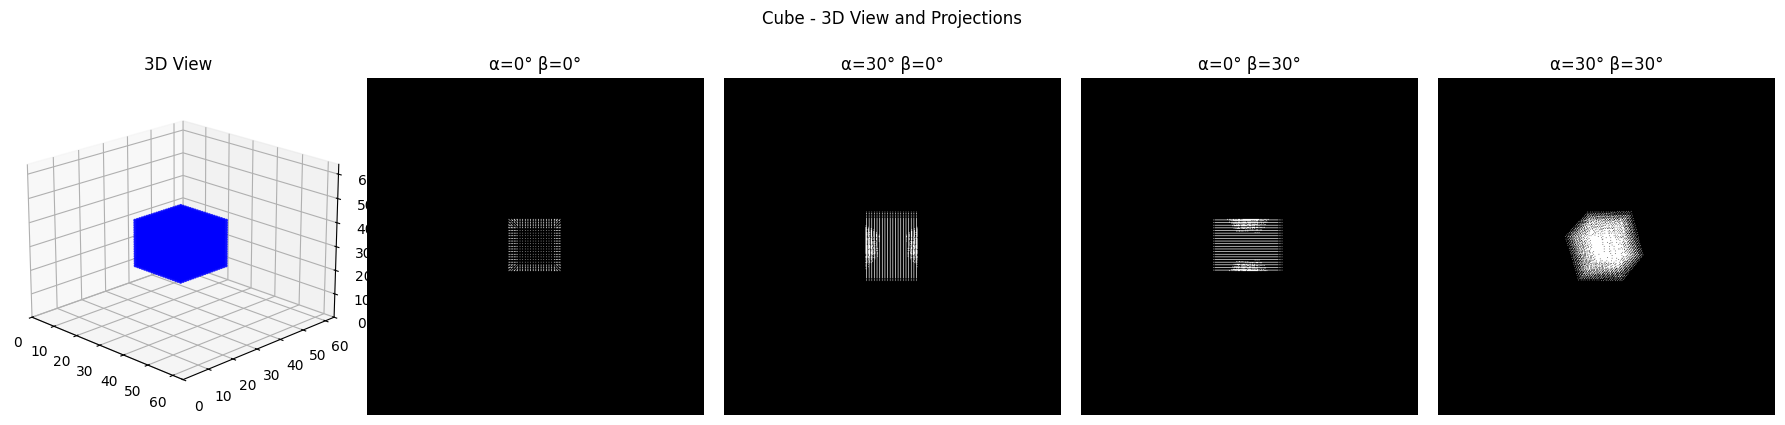


Visualizing Cylinder...


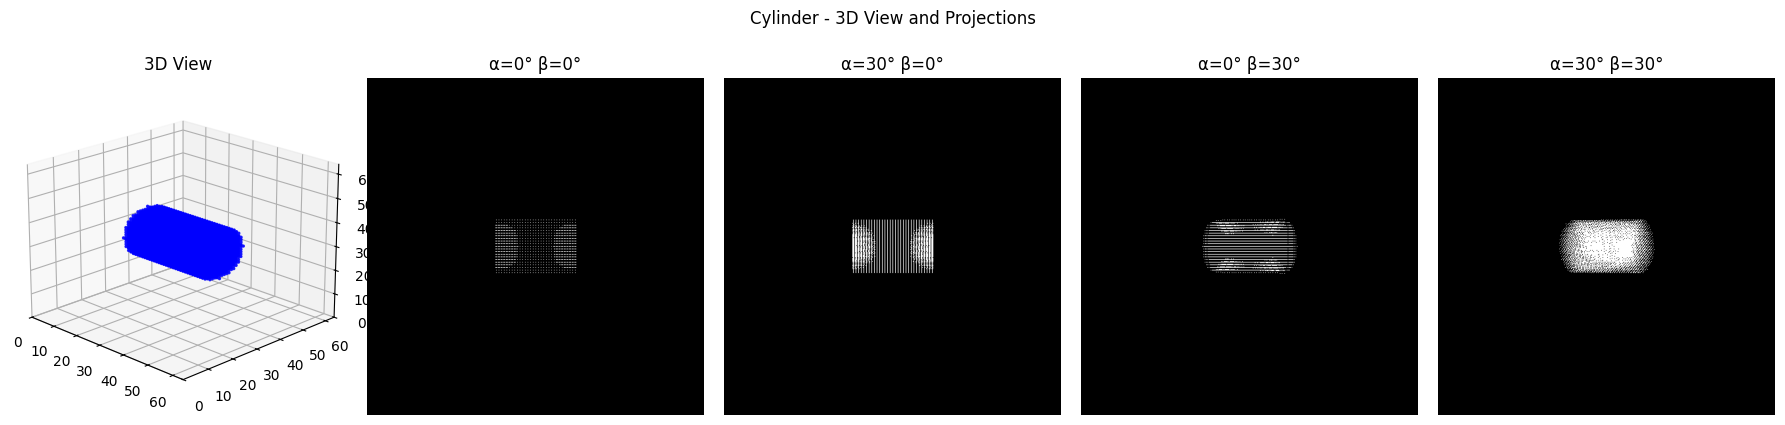


Visualizing Star...


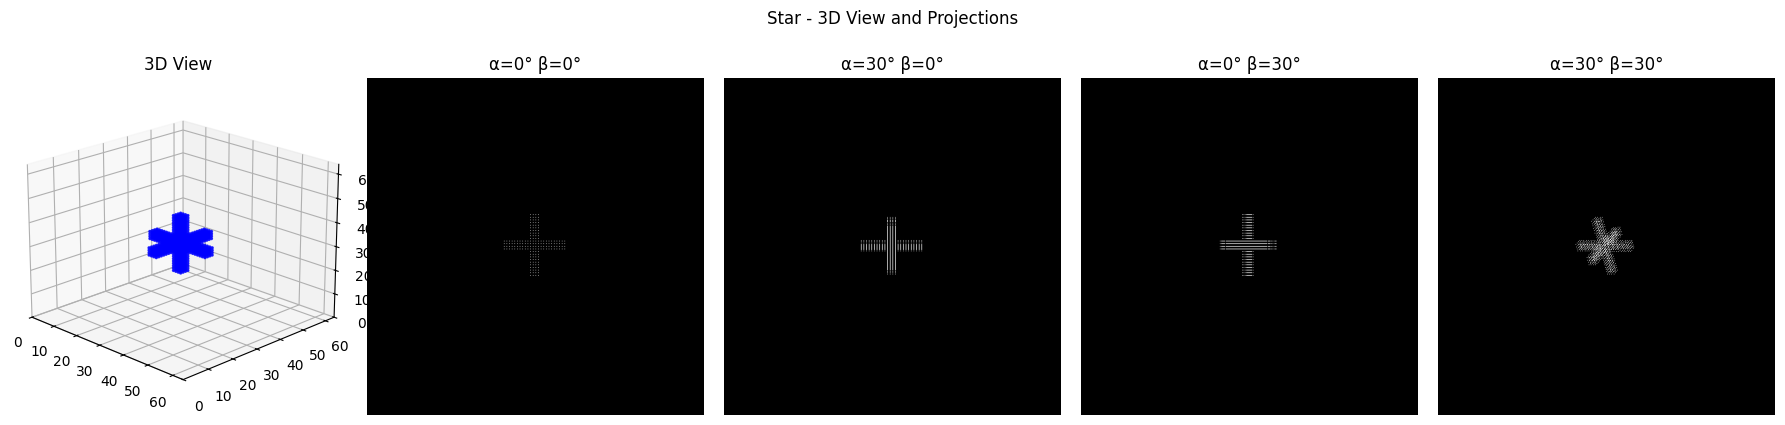


Visualizing Sphere...


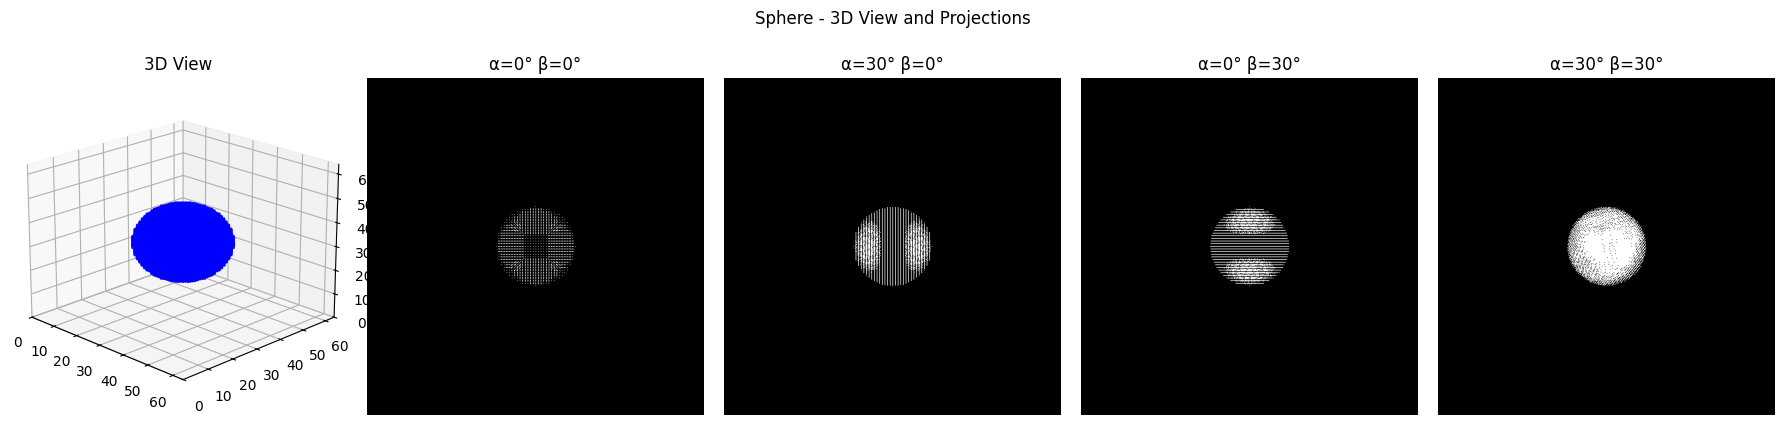


Visualizing Torus...


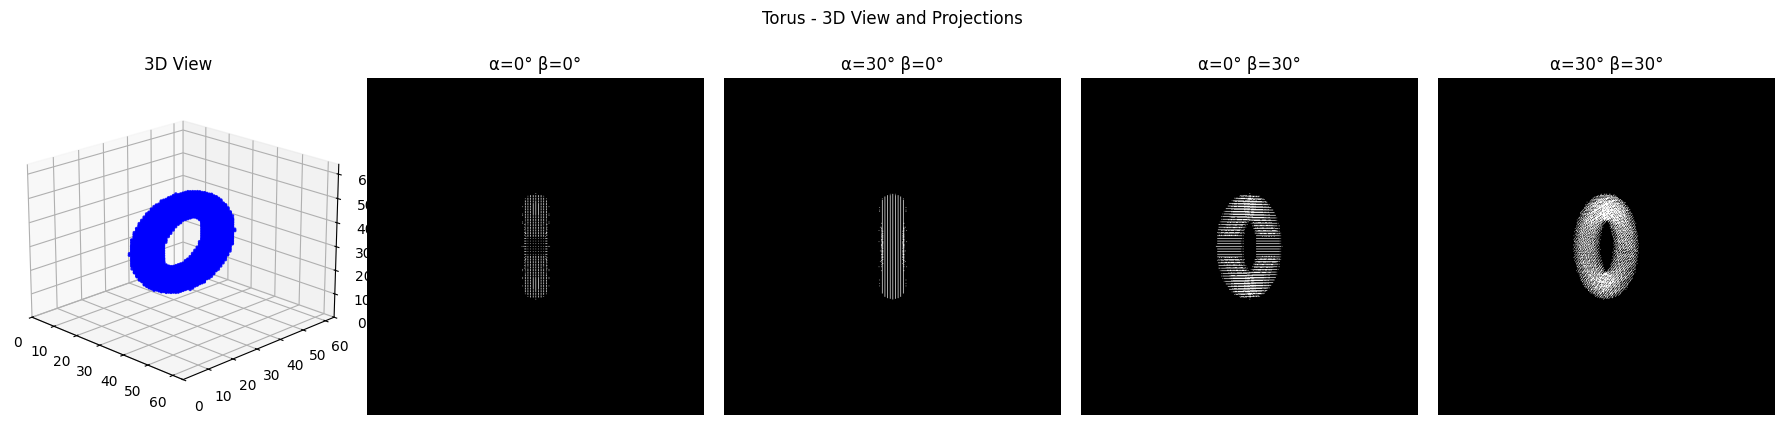


Visualizing Pyramid...


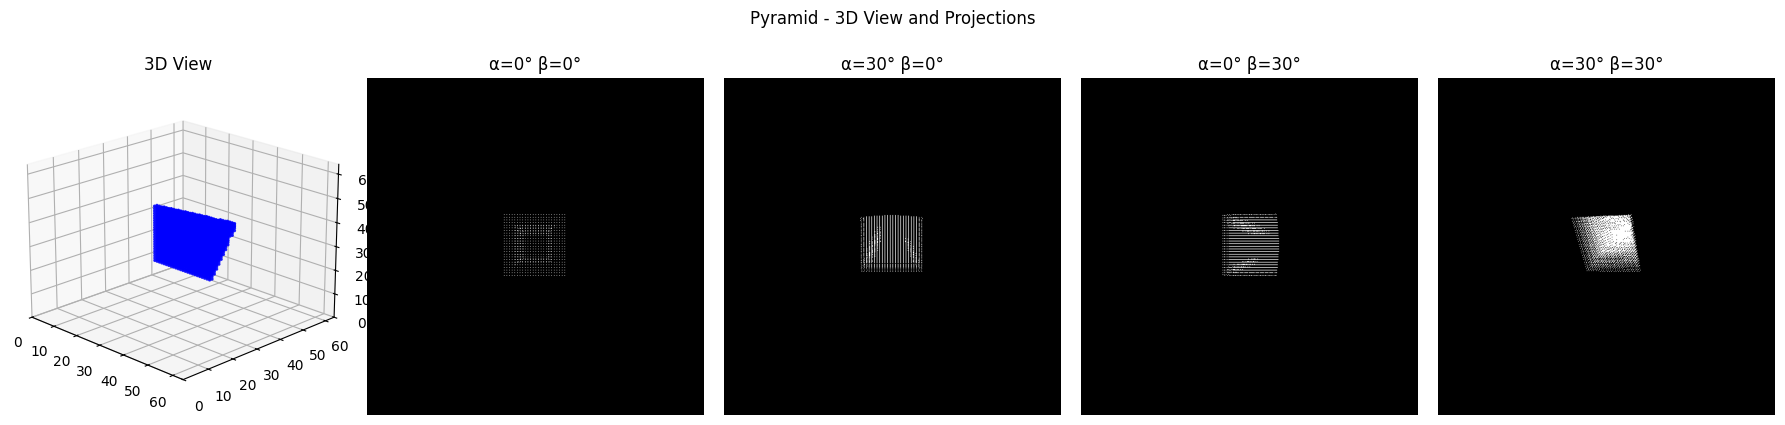


Visualizing Helix...


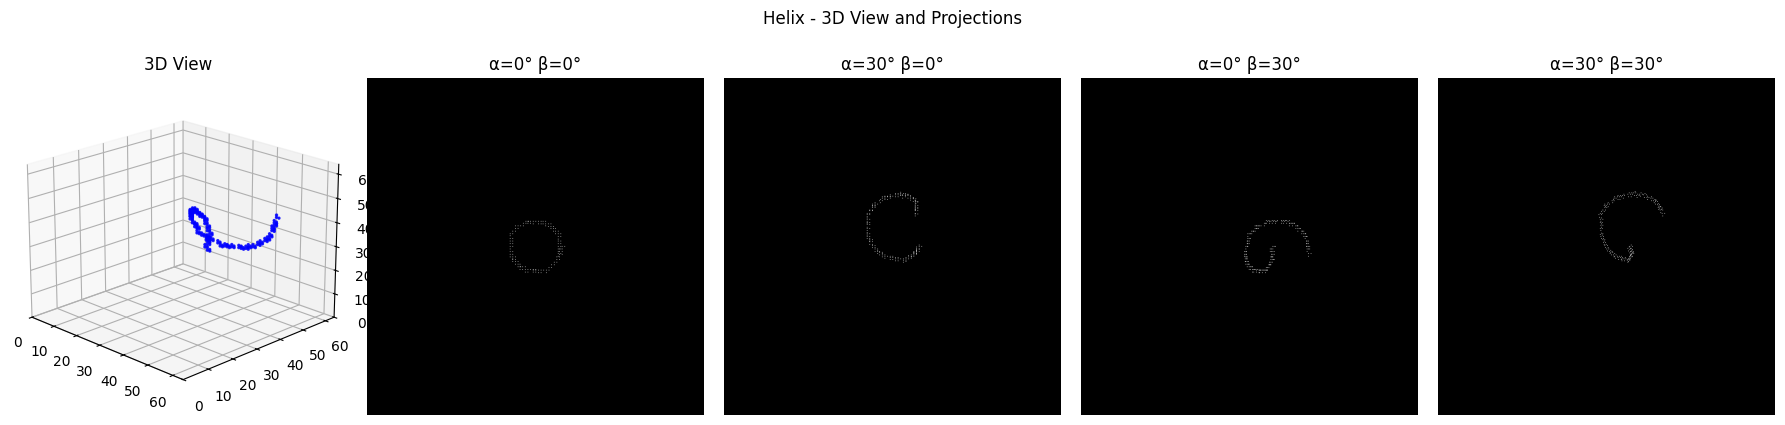

In [5]:
def plot_3d_voxels(voxels, title):
    """Visualize 3D voxels with consistent coordinate system"""
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111, projection='3d')
    
    coords = torch.nonzero(voxels).cpu().numpy()
    if len(coords) > 0:
        # Plot as (X, Z, Y) to match projection views
        ax.scatter(coords[:, 2], coords[:, 0], coords[:, 1],
                  color='blue', s=2, alpha=0.8, depthshade=True)
    
    ax.set_xlabel('X (Horizontal)')
    ax.set_ylabel('Z (Depth)')
    ax.set_zlabel('Y (Vertical)')
    ax.set_title(title, pad=10)
    ax.set_xlim(0, voxels.shape[2])
    ax.set_ylim(0, voxels.shape[0])
    ax.set_zlim(0, voxels.shape[1])
    ax.view_init(elev=20, azim=-45)  # Standard isometric view
    plt.tight_layout()
    plt.show()

def visualize_all_objects(test_objects, projector):
    """Visualize 3D objects and their X-ray projections"""
    angles = [
        (0, 0),          # Front view
        (math.pi/6, 0),  # 30° X-rotation
        (0, math.pi/6),  # 30° Y-rotation
        (math.pi/6, math.pi/6)  # Combined rotation
    ]
    
    for obj_name, obj_volume in test_objects.items():
        print(f"\nVisualizing {obj_name}...")
        
        # Combined visualization
        fig = plt.figure(figsize=(18, 4))
        fig.suptitle(f'{obj_name} - 3D View and Projections', y=1.05)
        
        # 3D View (subplot 1)
        ax_3d = fig.add_subplot(1, 5, 1, projection='3d')
        coords = torch.nonzero(obj_volume).cpu().numpy()
        if len(coords) > 0:
            ax_3d.scatter(coords[:, 2], coords[:, 0], coords[:, 1],
                         color='blue', s=2, alpha=0.8)
        ax_3d.set_title('3D View')
        ax_3d.set_xlim(0, obj_volume.shape[2])
        ax_3d.set_ylim(0, obj_volume.shape[0])
        ax_3d.set_zlim(0, obj_volume.shape[1])
        ax_3d.view_init(elev=20, azim=-45)
        
        # Projections (subplots 2-5)
        for i, (alpha, beta) in enumerate(angles):
            ax = fig.add_subplot(1, 5, i+2)
            proj_image = projector.project_volume(obj_volume, alpha, beta)
            ax.imshow(proj_image.cpu().numpy(), cmap='gray')
            ax.set_title(f'α={math.degrees(alpha):.0f}° β={math.degrees(beta):.0f}°')
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()

# Initialize and run visualization
volume_shape = (64, 64, 64)
projector = MatrixXRayProjector(volume_shape, (512, 512), (0.5, 0.5), 500.0, 1000.0)
test_objects = create_test_objects(volume_shape)
visualize_all_objects(test_objects, projector)

### 3. Reconstruction

#### 3.1 Reconstruction Framework (including visualization for evaluation)

In [6]:
def reconstruct_from_projections(test_objects, projector, num_iterations=5000, lr=0.01):
    """Reconstruct 3D objects from their projections using optimization"""
    results = {}
    angles = [
        (0, 0),          # Front view
        (math.pi/6, 0),  # 30° X-rotation
        (0, math.pi/6),  # 30° Y-rotation
        (math.pi/6, math.pi/6)  # Combined rotation
    ]
    
    for obj_name, true_volume in test_objects.items():
        print(f"\nReconstructing {obj_name}...")
        
        # 1. Get the ground truth projections (I_k)
        projections = []
        projection_matrices = []
        for alpha, beta in angles:
            P = projector.build_projection_matrix(alpha, beta)
            I_k = projector.project_volume(true_volume, alpha, beta)
            projections.append(I_k)
            #print(I_k.float().max(),I_k.float().min())
            projection_matrices.append(P)

        #P = projection_matrices[0]
        #test_input = torch.ones(volume_shape).flatten().to(device)
        #output = torch.sparse.mm(P, test_input.unsqueeze(-1)).max()
        #print(f"全1输入时的最大投影值: {output.item()}")  # 如果>>1，说明需要归一化

        #P = projection_matrices[0]
        #print(f"Projection matrix max value: {P._values().max().item()}")
        #if P._values().max() > 1.0:
            #for P in projection_matrices:
                #P._values().div_(P._values().max())
        #print(f"Projection matrix min value: {P._values().min().item()}")
        #if P._values().min() > 1.0:
            #for P in projection_matrices:
                #P._values().div_(P._values().min())
        
        # 2. Initialize the reconstructed volume (relaxed to [0,1])
        X_recon = torch.rand(projector.volume_shape, device=device, requires_grad=True)
        
        # 3. Set up optimizer
        optimizer = torch.optim.Adam([X_recon], lr=lr)
        
        # 4. Optimization loop
        loss_history = []
        best_loss = float('inf')
        best_X = None
        
        for iteration in tqdm(range(num_iterations)):
            optimizer.zero_grad()
            
            # Compute all projections
            total_loss = 0
            vec_X = X_recon.flatten()
            
            for P, I_k in zip(projection_matrices, projections):
                # Compute P·vec(X)
                proj = torch.sparse.mm(P, vec_X.unsqueeze(-1)).squeeze()
                #proj = proj.reshape(I_k.shape)# 不加max operator（也就是可能存在很多值为1的cube投影到同一个pixel）
                proj = proj.clamp(max=1.0).reshape(I_k.shape)
                
                # Compute Frobenius norm squared
                loss = torch.norm(proj - I_k.float(), p='fro')**2
                total_loss += loss
            
            # Add regularization to encourage binary solutions
            # This helps push values toward 0 or 1
            #reg = torch.norm(X_recon * (1 - X_recon), p=1)  # Encourages values to be 0 or 1
            #total_loss += 5 * reg
            
            # Track best solution
            if total_loss.item() < best_loss:
                best_loss = total_loss.item()
                best_X = X_recon.detach().clone()
            
            loss_history.append(total_loss.item())
            
            # Backpropagate and update
            total_loss.backward()
            if iteration % 100 == 0:
                grad_norm = X_recon.grad.norm().item()
                print(f"Iter {iter}: Loss={total_loss.item():.2f}, Grad Norm={grad_norm:.4f}")
            optimizer.step()
            
            # Project back to [0,1] range
            with torch.no_grad():
                X_recon.data = torch.clamp(X_recon, 0, 1)

        print(total_loss)

def visualize_reconstruction_results(results):
    """Visualize true and reconstructed volumes"""
    for obj_name, data in results.items():
        fig = plt.figure(figsize=(12, 4))
        fig.suptitle(f'Reconstruction Results for {obj_name}', y=1.05)
        
        # True volume
        ax1 = fig.add_subplot(131, projection='3d')
        coords = torch.nonzero(data['true']).cpu().numpy()
        if len(coords) > 0:
            ax1.scatter(coords[:, 2], coords[:, 0], coords[:, 1],
                      color='blue', s=2, alpha=0.8)
        ax1.set_title('True Volume')
        ax1.set_xlim(0, data['true'].shape[2])
        ax1.set_ylim(0, data['true'].shape[0])
        ax1.set_zlim(0, data['true'].shape[1])
        ax1.view_init(elev=20, azim=-45)
        
        # Reconstructed volume (binary)
        ax2 = fig.add_subplot(132, projection='3d')
        coords = torch.nonzero(data['reconstructed']).cpu().numpy()
        if len(coords) > 0:
            ax2.scatter(coords[:, 2], coords[:, 0], coords[:, 1],
                       color='red', s=2, alpha=0.8)
        ax2.set_title('Reconstructed Volume')
        ax2.set_xlim(0, data['reconstructed'].shape[2])
        ax2.set_ylim(0, data['reconstructed'].shape[0])
        ax2.set_zlim(0, data['reconstructed'].shape[1])
        ax2.view_init(elev=20, azim=-45)
        
        # Loss curve
        ax3 = fig.add_subplot(133)
        ax3.plot(data['loss_history'])
        ax3.set_title('Optimization Loss')
        ax3.set_xlabel('Iteration')
        ax3.set_ylabel('Loss')
        ax3.grid(True)
        
        plt.tight_layout()
        plt.show()

#### 3.2 Some necessary regular test before reconstruction


Testing with Ground Truth Initialization: Cube
Initial Loss (should be 0): 0.000000
Iter 0: Loss=0.000000, Grad Norm=0.000000
Iter 10: Loss=0.000000, Grad Norm=0.000000
Iter 20: Loss=0.000000, Grad Norm=0.000000
Iter 30: Loss=0.000000, Grad Norm=0.000000
Iter 40: Loss=0.000000, Grad Norm=0.000000
Iter 50: Loss=0.000000, Grad Norm=0.000000
Iter 60: Loss=0.000000, Grad Norm=0.000000
Iter 70: Loss=0.000000, Grad Norm=0.000000
Iter 80: Loss=0.000000, Grad Norm=0.000000
Iter 90: Loss=0.000000, Grad Norm=0.000000
Final Difference from Ground Truth: 0.000000

Testing with Ground Truth Initialization: Cylinder
Initial Loss (should be 0): 0.000000
Iter 0: Loss=0.000000, Grad Norm=0.000000
Iter 10: Loss=0.000000, Grad Norm=0.000000
Iter 20: Loss=0.000000, Grad Norm=0.000000
Iter 30: Loss=0.000000, Grad Norm=0.000000
Iter 40: Loss=0.000000, Grad Norm=0.000000
Iter 50: Loss=0.000000, Grad Norm=0.000000
Iter 60: Loss=0.000000, Grad Norm=0.000000
Iter 70: Loss=0.000000, Grad Norm=0.000000
Iter 80: 

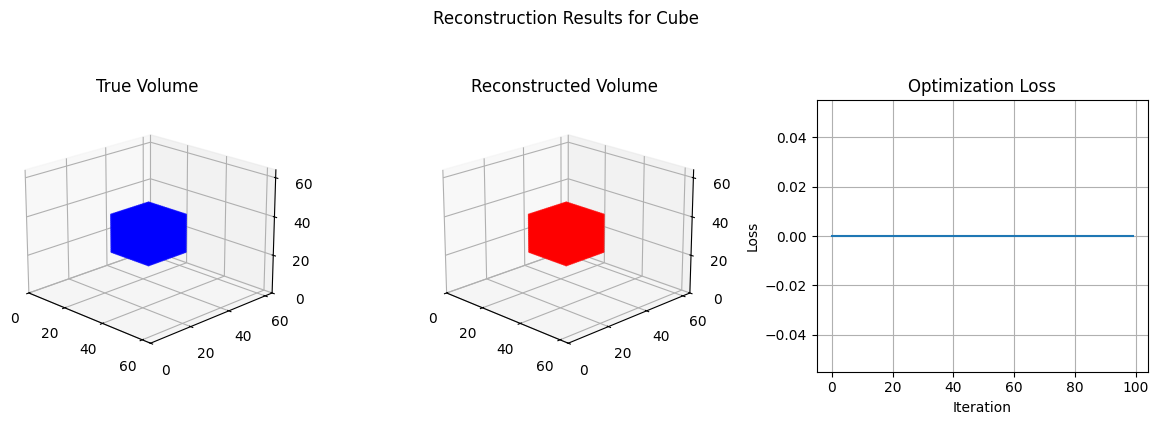

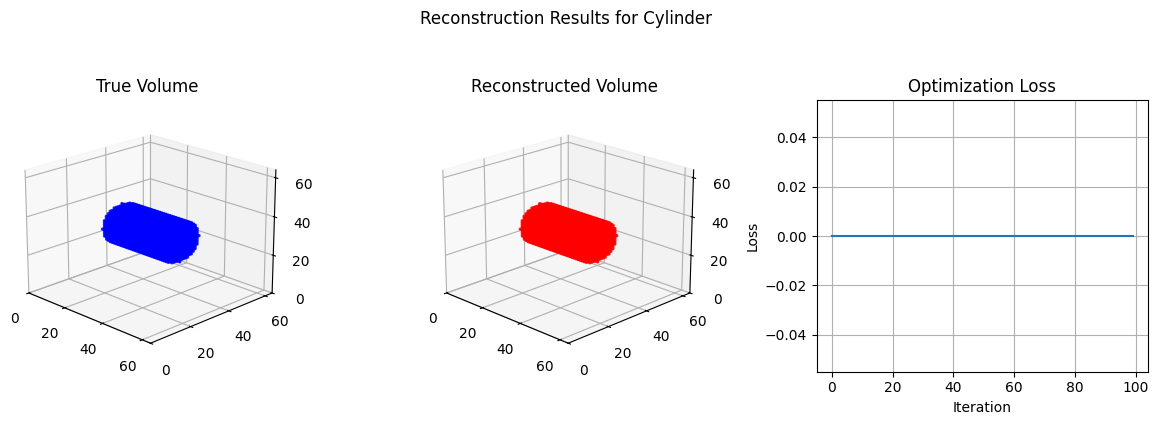

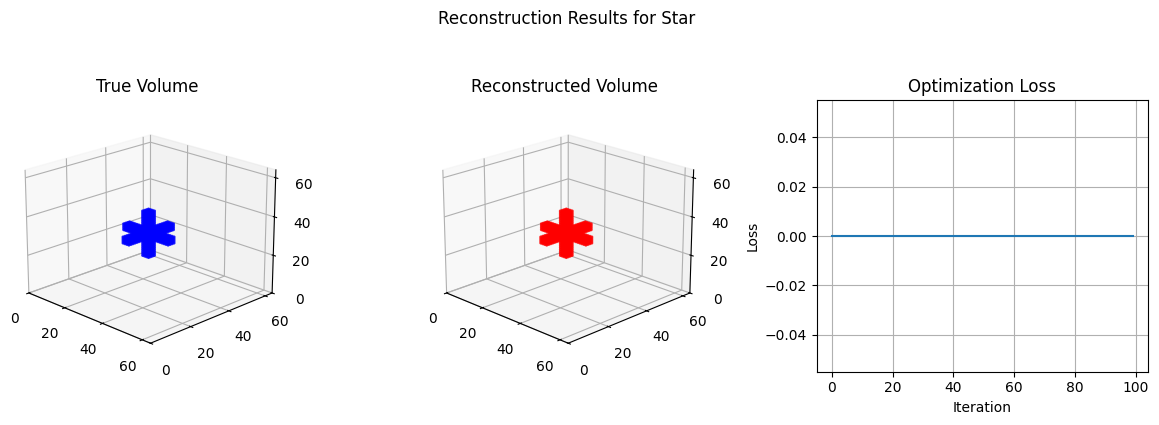

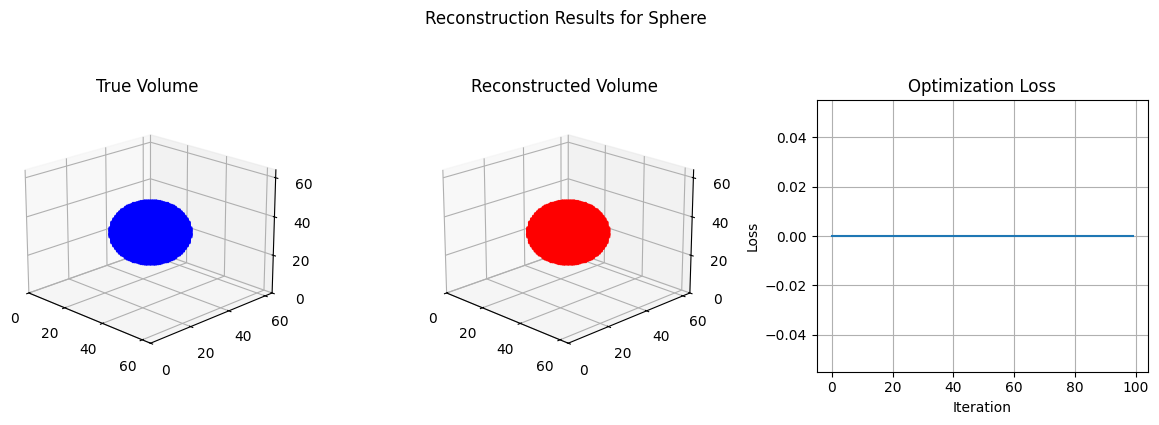

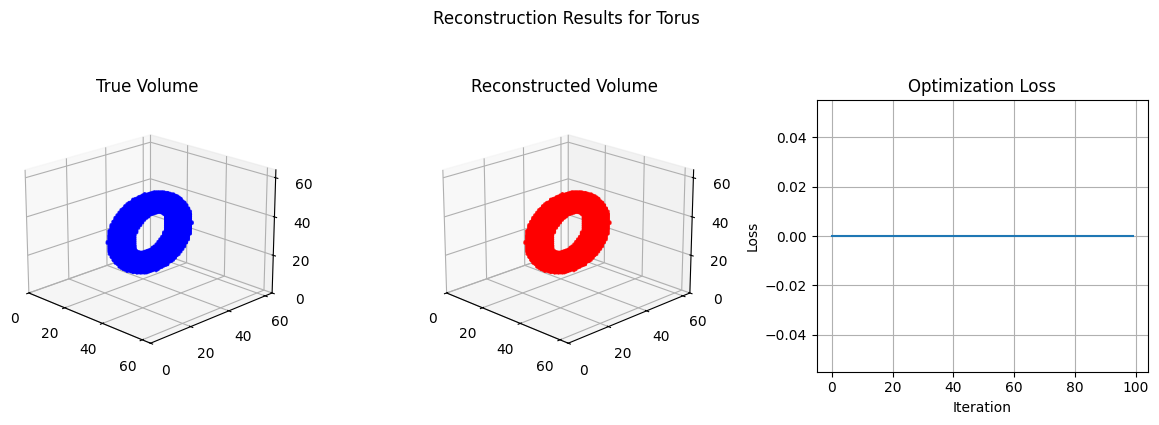

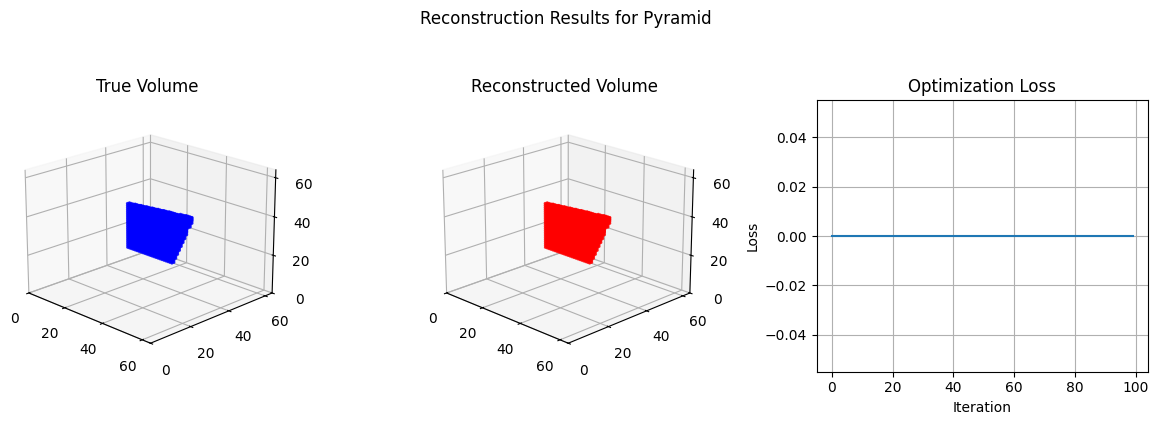

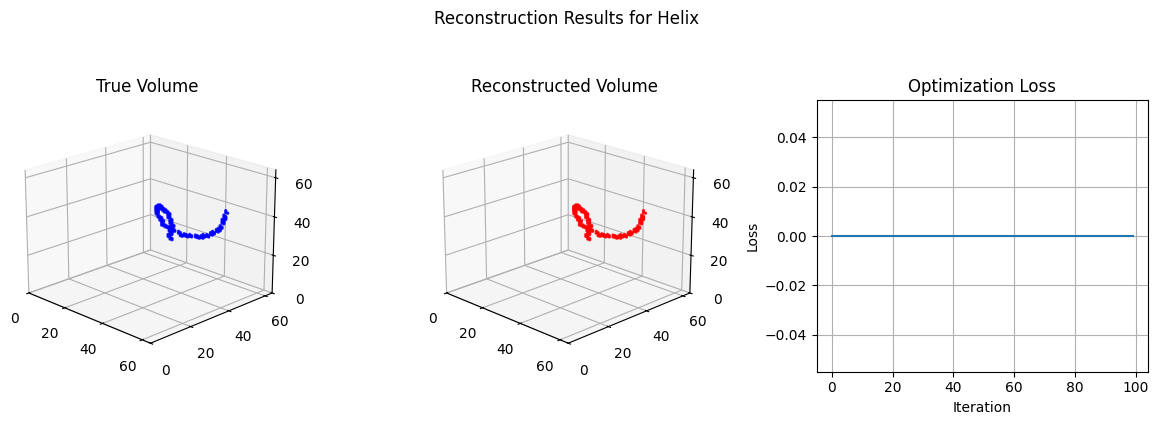

In [8]:
def reconstruct_with_ground_truth_init(test_objects, projector, num_iterations=100, lr=0.001):
    """使用ground truth作为initialization进行验证性优化，如果优化loss为0则优化过程没问题"""
    results = {}
    angles = [(0,0), (math.pi/6,0), (0,math.pi/6), (math.pi/6,math.pi/6)]
    
    for obj_name, true_volume in test_objects.items():
        print(f"\nTesting with Ground Truth Initialization: {obj_name}")
        
        # 1. projection data:
        projections = []
        projection_matrices = []
        for alpha, beta in angles:
            P = projector.build_projection_matrix(alpha, beta)
            I_k = projector.project_volume(true_volume, alpha, beta)
            projections.append(I_k)
            projection_matrices.append(P)

        # 2. use ground truth as initialization:
        X_recon = true_volume.clone().float().requires_grad_(True)
        
        # 3. optimizer:
        optimizer = torch.optim.Adam([X_recon], lr=lr)
        loss_history = []

        # 4. optimization:
        for iteration in range(num_iterations):
            optimizer.zero_grad()
            
            # loss calculation:
            total_loss = 0
            vec_X = X_recon.flatten()
            for P, I_k in zip(projection_matrices, projections):
                proj = torch.sparse.mm(P, vec_X.unsqueeze(-1)).squeeze()
                proj = proj.clamp(max=1.0).reshape(I_k.shape)
                loss = torch.norm(proj - I_k.float(), p='fro')**2
                total_loss += loss
            
            # print loss
            if iteration == 0:
                print(f"Initial Loss (should be 0): {total_loss.item():.6f}")
            
            loss_history.append(total_loss.item())
            
            total_loss.backward()
            optimizer.step()
            
            # print gradient norm
            if iteration % 10 == 0:
                grad_norm = X_recon.grad.norm().item() if X_recon.grad is not None else 0.0
                print(f"Iter {iteration}: Loss={total_loss.item():.6f}, Grad Norm={grad_norm:.6f}")

        # 5. final result:
        diff = torch.norm(X_recon - true_volume).item()
        print(f"Final Difference from Ground Truth: {diff:.6f}")
        
        # store results:
        results[obj_name] = {
            'true': true_volume,
            'reconstructed': X_recon.detach(),
            'loss_history': loss_history
        }
    
    return results

if __name__ == "__main__":
    volume_shape = (64, 64, 64)
    projector = MatrixXRayProjector(volume_shape, (512, 512), (0.5, 0.5), 500.0, 1000.0)
    test_objects = create_test_objects(volume_shape)
    
    # use GT for validation
    reconstruction_results = reconstruct_with_ground_truth_init(test_objects, projector)
    
    # visualization (GT = reconstruction)
    visualize_reconstruction_results(reconstruction_results)

In [9]:
def validate_ground_truth_loss(test_objects, projector):#检验是否ground truth的loss等于0
    """validate loss of ground truth equal to 0"""
    angles = [(0,0), (math.pi/6,0), (0,math.pi/6), (math.pi/6,math.pi/6)]
    
    for obj_name, true_volume in test_objects.items():
        print(f"\nValidating {obj_name}...")
        total_loss = 0
        
        # 计算ground truth的loss
        for alpha, beta in angles:
            P = projector.build_projection_matrix(alpha, beta)
            I_k = projector.project_volume(true_volume, alpha, beta)
            
            # 计算P·vec(X_blue)
            proj = torch.sparse.mm(P, true_volume.flatten().unsqueeze(-1)).squeeze()
            proj = proj.reshape(I_k.shape).clamp(max=1.0)  # 与重建时一致
            
            loss = torch.norm(proj - I_k.float(), p='fro')**2
            total_loss += loss
            print(f"View ({alpha:.2f}, {beta:.2f}) Loss: {loss.item():.2f}")
        
        print(f"Total Loss for {obj_name}: {total_loss.item():.2f} (should be 0)")

if __name__ == "__main__":
    volume_shape = (64, 64, 64)
    projector = MatrixXRayProjector(volume_shape, (512, 512), (0.5, 0.5), 500.0, 1000.0)
    test_objects = create_test_objects(volume_shape)
    
    # validate ground truth
    validate_ground_truth_loss(test_objects, projector)


Validating Cube...
View (0.00, 0.00) Loss: 0.00
View (0.52, 0.00) Loss: 0.00
View (0.00, 0.52) Loss: 0.00
View (0.52, 0.52) Loss: 0.00
Total Loss for Cube: 0.00 (should be 0)

Validating Cylinder...
View (0.00, 0.00) Loss: 0.00
View (0.52, 0.00) Loss: 0.00
View (0.00, 0.52) Loss: 0.00
View (0.52, 0.52) Loss: 0.00
Total Loss for Cylinder: 0.00 (should be 0)

Validating Star...
View (0.00, 0.00) Loss: 0.00
View (0.52, 0.00) Loss: 0.00
View (0.00, 0.52) Loss: 0.00
View (0.52, 0.52) Loss: 0.00
Total Loss for Star: 0.00 (should be 0)

Validating Sphere...
View (0.00, 0.00) Loss: 0.00
View (0.52, 0.00) Loss: 0.00
View (0.00, 0.52) Loss: 0.00
View (0.52, 0.52) Loss: 0.00
Total Loss for Sphere: 0.00 (should be 0)

Validating Torus...
View (0.00, 0.00) Loss: 0.00
View (0.52, 0.00) Loss: 0.00
View (0.00, 0.52) Loss: 0.00
View (0.52, 0.52) Loss: 0.00
Total Loss for Torus: 0.00 (should be 0)

Validating Pyramid...
View (0.00, 0.00) Loss: 0.00
View (0.52, 0.00) Loss: 0.00
View (0.00, 0.52) Loss: 0

#### 3.3 Reconstruction process


Reconstructing Cube...


  0%|          | 5/1000 [00:00<00:24, 40.97it/s]

Iter <built-in function iter>: Loss=215063.75, Grad Norm=600.0051


 11%|█         | 106/1000 [00:02<00:17, 51.83it/s]

Iter <built-in function iter>: Loss=117776.34, Grad Norm=421.7031


 21%|██        | 207/1000 [00:04<00:15, 50.49it/s]

Iter <built-in function iter>: Loss=61814.49, Grad Norm=311.6854


 31%|███       | 309/1000 [00:06<00:13, 50.10it/s]

Iter <built-in function iter>: Loss=25724.78, Grad Norm=259.2126


 41%|████      | 410/1000 [00:08<00:11, 49.38it/s]

Iter <built-in function iter>: Loss=6208.78, Grad Norm=139.5369


 51%|█████     | 510/1000 [00:10<00:09, 51.36it/s]

Iter <built-in function iter>: Loss=3089.52, Grad Norm=34.4352


 61%|██████    | 606/1000 [00:11<00:07, 51.16it/s]

Iter <built-in function iter>: Loss=2928.29, Grad Norm=8.2225


 71%|███████   | 708/1000 [00:13<00:05, 49.97it/s]

Iter <built-in function iter>: Loss=2925.00, Grad Norm=0.0000


 81%|████████  | 810/1000 [00:15<00:03, 51.58it/s]

Iter <built-in function iter>: Loss=2925.00, Grad Norm=0.0000


 91%|█████████ | 906/1000 [00:17<00:01, 51.73it/s]

Iter <built-in function iter>: Loss=2925.00, Grad Norm=0.0000


100%|██████████| 1000/1000 [00:19<00:00, 50.92it/s]


tensor(2925., device='cuda:0', grad_fn=<AddBackward0>)

Reconstructing Cylinder...


  1%|          | 6/1000 [00:00<00:19, 50.84it/s]

Iter <built-in function iter>: Loss=212015.34, Grad Norm=600.2749


 11%|█         | 108/1000 [00:02<00:17, 51.51it/s]

Iter <built-in function iter>: Loss=116032.03, Grad Norm=418.8990


 21%|██        | 210/1000 [00:04<00:15, 50.19it/s]

Iter <built-in function iter>: Loss=61012.19, Grad Norm=308.6915


 31%|███       | 309/1000 [00:06<00:14, 48.91it/s]

Iter <built-in function iter>: Loss=26169.72, Grad Norm=248.2408


 41%|████      | 408/1000 [00:08<00:11, 50.35it/s]

Iter <built-in function iter>: Loss=7736.61, Grad Norm=134.4285


 51%|█████     | 506/1000 [00:10<00:10, 48.82it/s]

Iter <built-in function iter>: Loss=4420.78, Grad Norm=44.4687


 61%|██████    | 611/1000 [00:12<00:07, 51.17it/s]

Iter <built-in function iter>: Loss=3992.14, Grad Norm=18.7071


 71%|███████   | 707/1000 [00:14<00:05, 51.14it/s]

Iter <built-in function iter>: Loss=3902.86, Grad Norm=7.3166


 81%|████████  | 809/1000 [00:16<00:03, 51.42it/s]

Iter <built-in function iter>: Loss=3881.00, Grad Norm=0.0245


 91%|█████████ | 911/1000 [00:18<00:01, 51.22it/s]

Iter <built-in function iter>: Loss=3881.00, Grad Norm=0.0000


100%|██████████| 1000/1000 [00:19<00:00, 50.52it/s]


tensor(3881.0002, device='cuda:0', grad_fn=<AddBackward0>)

Reconstructing Star...


  0%|          | 5/1000 [00:00<00:20, 48.97it/s]

Iter <built-in function iter>: Loss=224521.00, Grad Norm=600.3571


 11%|█         | 107/1000 [00:02<00:17, 51.13it/s]

Iter <built-in function iter>: Loss=126833.22, Grad Norm=431.7877


 21%|██        | 209/1000 [00:04<00:15, 51.14it/s]

Iter <built-in function iter>: Loss=69416.94, Grad Norm=323.0699


 30%|███       | 305/1000 [00:05<00:13, 51.18it/s]

Iter <built-in function iter>: Loss=28573.14, Grad Norm=280.6322


 41%|████      | 407/1000 [00:07<00:11, 50.97it/s]

Iter <built-in function iter>: Loss=5239.88, Grad Norm=144.7651


 51%|█████     | 509/1000 [00:09<00:09, 51.28it/s]

Iter <built-in function iter>: Loss=1509.51, Grad Norm=70.0689


 61%|██████    | 611/1000 [00:11<00:07, 50.99it/s]

Iter <built-in function iter>: Loss=438.01, Grad Norm=31.9168


 71%|███████   | 707/1000 [00:13<00:05, 51.27it/s]

Iter <built-in function iter>: Loss=213.51, Grad Norm=10.6492


 81%|████████  | 809/1000 [00:15<00:03, 51.23it/s]

Iter <built-in function iter>: Loss=192.13, Grad Norm=2.0374


 91%|█████████ | 911/1000 [00:17<00:01, 50.76it/s]

Iter <built-in function iter>: Loss=192.00, Grad Norm=0.0000


100%|██████████| 1000/1000 [00:19<00:00, 51.02it/s]


tensor(192., device='cuda:0', grad_fn=<AddBackward0>)

Reconstructing Sphere...


  0%|          | 5/1000 [00:00<00:19, 49.97it/s]

Iter <built-in function iter>: Loss=207906.91, Grad Norm=598.1855


 11%|█         | 107/1000 [00:02<00:17, 51.23it/s]

Iter <built-in function iter>: Loss=111683.20, Grad Norm=419.5029


 21%|██        | 209/1000 [00:04<00:15, 50.44it/s]

Iter <built-in function iter>: Loss=58240.77, Grad Norm=305.2576


 31%|███       | 311/1000 [00:06<00:13, 50.66it/s]

Iter <built-in function iter>: Loss=25101.68, Grad Norm=234.8043


 41%|████      | 407/1000 [00:07<00:11, 50.93it/s]

Iter <built-in function iter>: Loss=7465.80, Grad Norm=118.1751


 51%|█████     | 509/1000 [00:09<00:09, 50.71it/s]

Iter <built-in function iter>: Loss=4414.57, Grad Norm=48.9859


 61%|██████    | 611/1000 [00:11<00:07, 50.44it/s]

Iter <built-in function iter>: Loss=3818.16, Grad Norm=18.5813


 71%|███████   | 710/1000 [00:13<00:05, 49.70it/s]

Iter <built-in function iter>: Loss=3733.09, Grad Norm=6.6709


 81%|████████  | 811/1000 [00:15<00:03, 50.46it/s]

Iter <built-in function iter>: Loss=3727.00, Grad Norm=0.0006


 91%|█████████ | 907/1000 [00:17<00:01, 50.45it/s]

Iter <built-in function iter>: Loss=3727.00, Grad Norm=0.0000


100%|██████████| 1000/1000 [00:19<00:00, 50.68it/s]


tensor(3727., device='cuda:0', grad_fn=<AddBackward0>)

Reconstructing Torus...


  0%|          | 5/1000 [00:00<00:20, 49.48it/s]

Iter <built-in function iter>: Loss=214268.78, Grad Norm=601.6433


 11%|█         | 107/1000 [00:02<00:17, 50.14it/s]

Iter <built-in function iter>: Loss=116433.51, Grad Norm=423.8127


 21%|██        | 208/1000 [00:04<00:15, 49.79it/s]

Iter <built-in function iter>: Loss=61741.64, Grad Norm=308.0661


 31%|███       | 309/1000 [00:06<00:13, 50.13it/s]

Iter <built-in function iter>: Loss=27601.49, Grad Norm=249.8175


 41%|████      | 411/1000 [00:08<00:11, 49.08it/s]

Iter <built-in function iter>: Loss=9402.67, Grad Norm=128.2867


 51%|█████     | 511/1000 [00:10<00:10, 48.12it/s]

Iter <built-in function iter>: Loss=5682.35, Grad Norm=51.1562


 61%|██████    | 611/1000 [00:12<00:08, 47.98it/s]

Iter <built-in function iter>: Loss=5040.95, Grad Norm=19.6606


 71%|███████   | 706/1000 [00:14<00:06, 47.58it/s]

Iter <built-in function iter>: Loss=4920.03, Grad Norm=4.5701


 81%|████████  | 807/1000 [00:16<00:03, 49.64it/s]

Iter <built-in function iter>: Loss=4919.00, Grad Norm=0.0000


 91%|█████████ | 907/1000 [00:18<00:01, 49.65it/s]

Iter <built-in function iter>: Loss=4919.00, Grad Norm=0.0000


100%|██████████| 1000/1000 [00:20<00:00, 49.22it/s]


tensor(4919., device='cuda:0', grad_fn=<AddBackward0>)

Reconstructing Pyramid...


  0%|          | 5/1000 [00:00<00:20, 48.49it/s]

Iter <built-in function iter>: Loss=217927.86, Grad Norm=601.6950


 11%|█         | 110/1000 [00:02<00:18, 49.25it/s]

Iter <built-in function iter>: Loss=120577.34, Grad Norm=429.2683


 21%|██        | 210/1000 [00:04<00:16, 49.06it/s]

Iter <built-in function iter>: Loss=64272.73, Grad Norm=317.8361


 31%|███       | 307/1000 [00:06<00:13, 49.52it/s]

Iter <built-in function iter>: Loss=26900.97, Grad Norm=269.7153


 41%|████      | 409/1000 [00:08<00:11, 49.99it/s]

Iter <built-in function iter>: Loss=4901.63, Grad Norm=133.7030


 51%|█████     | 509/1000 [00:10<00:09, 50.27it/s]

Iter <built-in function iter>: Loss=2683.33, Grad Norm=28.0007


 61%|██████    | 609/1000 [00:12<00:07, 49.87it/s]

Iter <built-in function iter>: Loss=2503.80, Grad Norm=7.4795


 71%|███████   | 707/1000 [00:14<00:05, 49.73it/s]

Iter <built-in function iter>: Loss=2492.00, Grad Norm=0.0000


 81%|████████  | 808/1000 [00:16<00:03, 49.20it/s]

Iter <built-in function iter>: Loss=2492.00, Grad Norm=0.0000


 91%|█████████ | 908/1000 [00:18<00:01, 49.15it/s]

Iter <built-in function iter>: Loss=2492.00, Grad Norm=0.0000


100%|██████████| 1000/1000 [00:20<00:00, 49.51it/s]


tensor(2492., device='cuda:0', grad_fn=<AddBackward0>)

Reconstructing Helix...


  0%|          | 5/1000 [00:00<00:21, 46.91it/s]

Iter <built-in function iter>: Loss=226209.45, Grad Norm=601.3707


 11%|█         | 110/1000 [00:02<00:18, 48.92it/s]

Iter <built-in function iter>: Loss=129360.36, Grad Norm=425.5578


 21%|██        | 210/1000 [00:04<00:16, 49.17it/s]

Iter <built-in function iter>: Loss=72103.63, Grad Norm=330.0504


 31%|███       | 310/1000 [00:06<00:13, 49.31it/s]

Iter <built-in function iter>: Loss=31250.67, Grad Norm=280.7589


 41%|████      | 410/1000 [00:08<00:12, 49.11it/s]

Iter <built-in function iter>: Loss=5925.08, Grad Norm=152.3387


 50%|█████     | 505/1000 [00:10<00:09, 49.55it/s]

Iter <built-in function iter>: Loss=374.01, Grad Norm=95.1530


 61%|██████    | 611/1000 [00:12<00:07, 49.45it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 71%|███████   | 710/1000 [00:14<00:05, 49.56it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 81%|████████  | 810/1000 [00:16<00:03, 48.90it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


 90%|█████████ | 905/1000 [00:18<00:01, 49.43it/s]

Iter <built-in function iter>: Loss=0.00, Grad Norm=0.0000


100%|██████████| 1000/1000 [00:20<00:00, 49.17it/s]


tensor(0., device='cuda:0', grad_fn=<AddBackward0>)


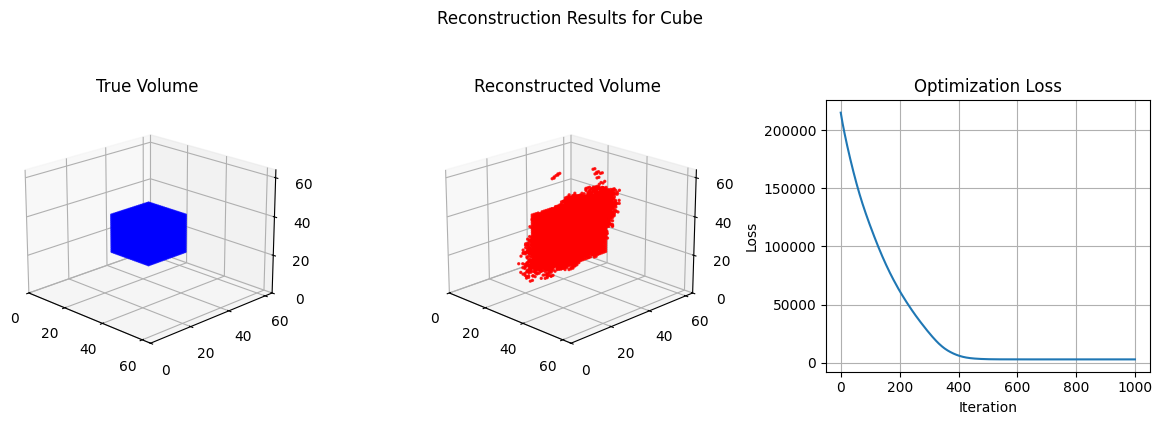

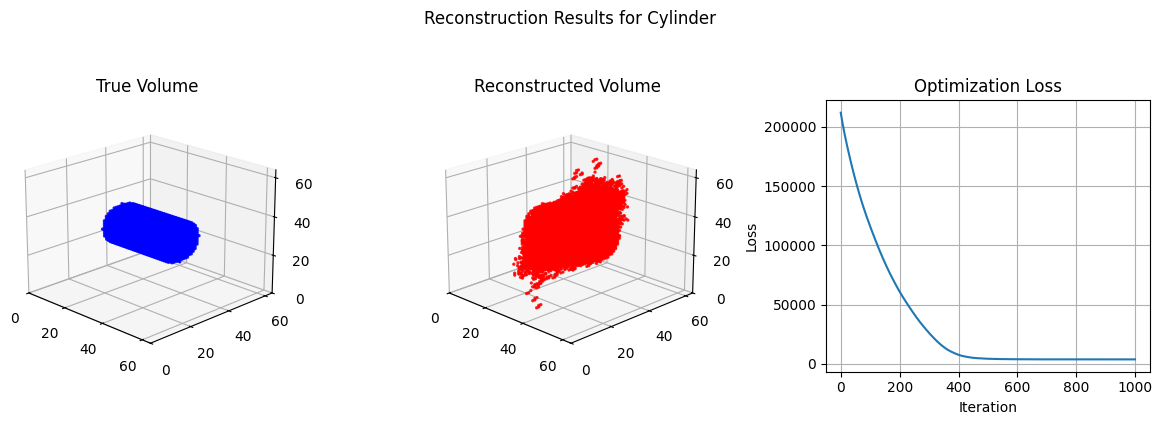

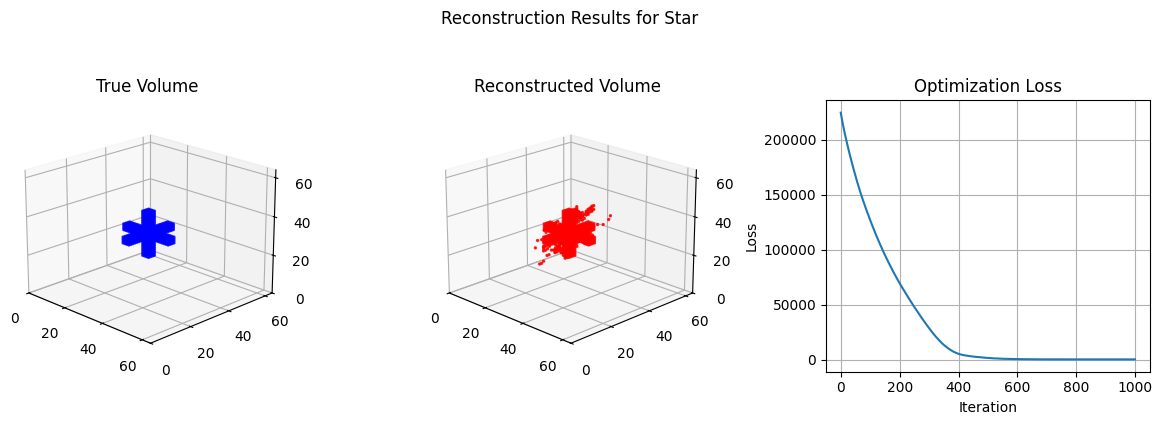

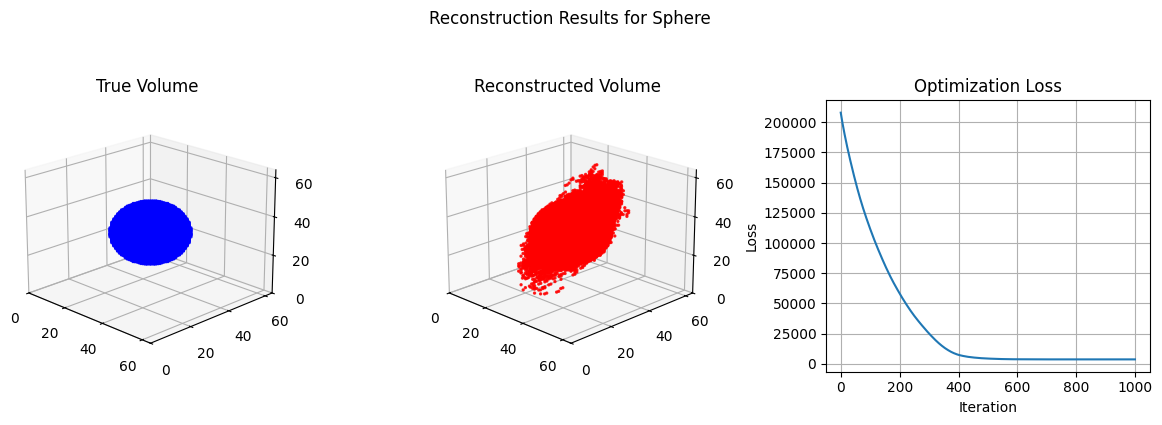

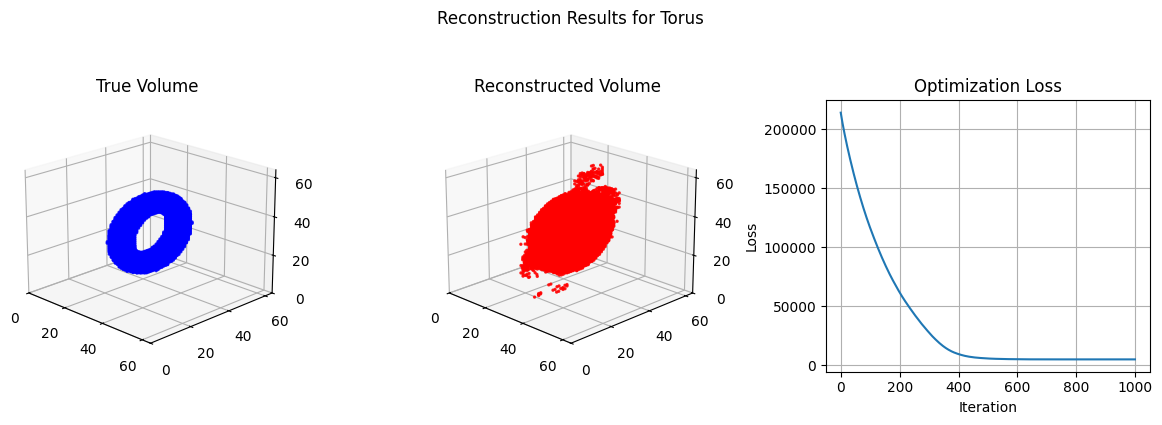

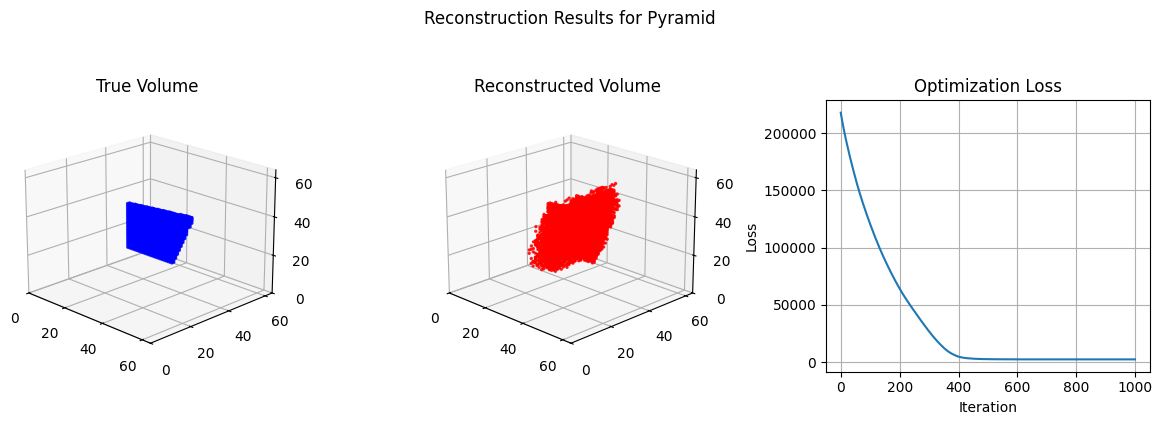

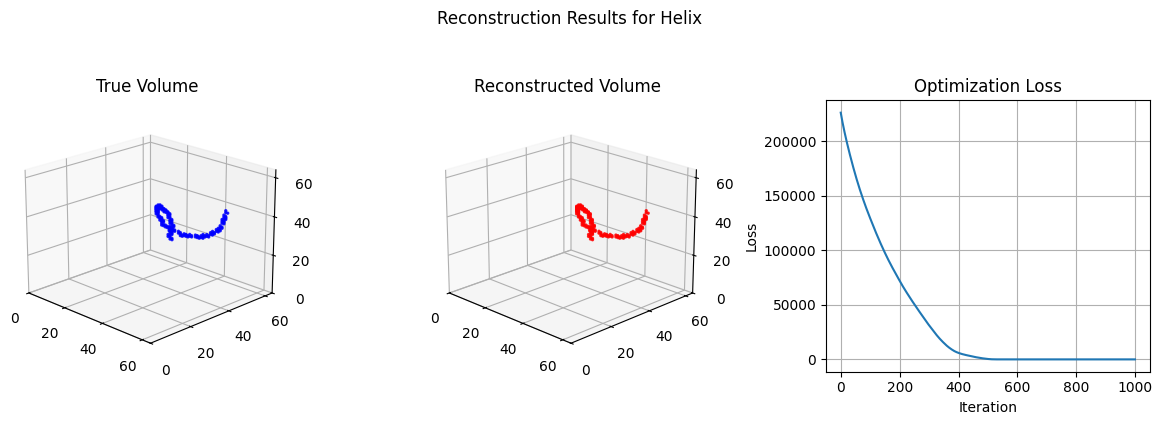

In [10]:
def reconstruct_from_projections(test_objects, projector, num_iterations=1000, lr=0.01):
    """Reconstruct 3D objects from their projections using optimization"""
    results = {}
    angles = [
        (0, 0),          # Front view
        (math.pi/6, 0),  # 30° X-rotation
        (0, math.pi/6),  # 30° Y-rotation
        (math.pi/6, math.pi/6)  # Combined rotation
    ]
    
    for obj_name, true_volume in test_objects.items():
        print(f"\nReconstructing {obj_name}...")
        
        # 1. Get the ground truth projections (I_k)
        projections = []
        projection_matrices = []
        for alpha, beta in angles:
            P = projector.build_projection_matrix(alpha, beta)
            I_k = projector.project_volume(true_volume, alpha, beta)
            projections.append(I_k)
            #print(I_k.float().max(),I_k.float().min())
            projection_matrices.append(P)

        #P = projection_matrices[0]
        #test_input = torch.ones(volume_shape).flatten().to(device)
        #output = torch.sparse.mm(P, test_input.unsqueeze(-1)).max()
        #print(f"全1输入时的最大投影值: {output.item()}")  # 如果>>1，说明需要归一化

        #P = projection_matrices[0]
        #print(f"Projection matrix max value: {P._values().max().item()}")
        #if P._values().max() > 1.0:
            #for P in projection_matrices:
                #P._values().div_(P._values().max())
        #print(f"Projection matrix min value: {P._values().min().item()}")
        #if P._values().min() > 1.0:
            #for P in projection_matrices:
                #P._values().div_(P._values().min())
        
        # 2. Initialize the reconstructed volume (relaxed to [0,1])
        X_recon = torch.rand(projector.volume_shape, device=device, requires_grad=True)
        
        # 3. Set up optimizer
        optimizer = torch.optim.Adam([X_recon], lr=lr)
        
        # 4. Optimization loop
        loss_history = []
        best_loss = float('inf')
        best_X = None
        
        for iteration in tqdm(range(num_iterations)):
            optimizer.zero_grad()
            
            # Compute all projections
            total_loss = 0
            vec_X = X_recon.flatten()
            
            for P, I_k in zip(projection_matrices, projections):
                # Compute P·vec(X)
                proj = torch.sparse.mm(P, vec_X.unsqueeze(-1)).squeeze()
                #proj = proj.reshape(I_k.shape)# 不加max operator（也就是可能存在很多值为1的cube投影到同一个pixel）
                proj = proj.clamp(max=1.0).reshape(I_k.shape)
                
                # Compute Frobenius norm squared
                loss = torch.norm(proj - I_k.float(), p='fro')**2
                total_loss += loss
            
            # Add regularization to encourage binary solutions
            # This helps push values toward 0 or 1
            #reg = torch.norm(X_recon * (1 - X_recon), p=1)  # Encourages values to be 0 or 1
            #total_loss += 5 * reg
            
            # Track best solution
            if total_loss.item() < best_loss:
                best_loss = total_loss.item()
                best_X = X_recon.detach().clone()
            
            loss_history.append(total_loss.item())
            
            # Backpropagate and update
            total_loss.backward()
            if iteration % 100 == 0:
                grad_norm = X_recon.grad.norm().item()
                print(f"Iter {iter}: Loss={total_loss.item():.2f}, Grad Norm={grad_norm:.4f}")
            optimizer.step()
            
            # Project back to [0,1] range
            with torch.no_grad():
                X_recon.data = torch.clamp(X_recon, 0, 1)

        print(total_loss)
        
        # 5. Store results (use the best solution found during optimization)
        threshold = 0.5  # For converting back to binary
        binary_recon = (best_X > threshold).float()
        results[obj_name] = {
            'true': true_volume,
            'reconstructed': binary_recon,
            'relaxed': best_X,
            'loss_history': loss_history
        }
    
    return results

def visualize_reconstruction_results(results):
    """Visualize true and reconstructed volumes"""
    for obj_name, data in results.items():
        fig = plt.figure(figsize=(12, 4))
        fig.suptitle(f'Reconstruction Results for {obj_name}', y=1.05)
        
        # True volume
        ax1 = fig.add_subplot(131, projection='3d')
        coords = torch.nonzero(data['true']).cpu().numpy()
        if len(coords) > 0:
            ax1.scatter(coords[:, 2], coords[:, 0], coords[:, 1],
                      color='blue', s=2, alpha=0.8)
        ax1.set_title('True Volume')
        ax1.set_xlim(0, data['true'].shape[2])
        ax1.set_ylim(0, data['true'].shape[0])
        ax1.set_zlim(0, data['true'].shape[1])
        ax1.view_init(elev=20, azim=-45)
        
        # Reconstructed volume (binary)
        ax2 = fig.add_subplot(132, projection='3d')
        coords = torch.nonzero(data['reconstructed']).cpu().numpy()
        if len(coords) > 0:
            ax2.scatter(coords[:, 2], coords[:, 0], coords[:, 1],
                       color='red', s=2, alpha=0.8)
        ax2.set_title('Reconstructed Volume')
        ax2.set_xlim(0, data['reconstructed'].shape[2])
        ax2.set_ylim(0, data['reconstructed'].shape[0])
        ax2.set_zlim(0, data['reconstructed'].shape[1])
        ax2.view_init(elev=20, azim=-45)
        
        # Loss curve
        ax3 = fig.add_subplot(133)
        ax3.plot(data['loss_history'])
        ax3.set_title('Optimization Loss')
        ax3.set_xlabel('Iteration')
        ax3.set_ylabel('Loss')
        ax3.grid(True)
        
        plt.tight_layout()
        plt.show()

# Main execution
if __name__ == "__main__":
    volume_shape = (64, 64, 64)
    projector = MatrixXRayProjector(volume_shape, (512, 512), (0.5, 0.5), 500.0, 1000.0)
    test_objects = create_test_objects(volume_shape)
    
    # First visualize the objects and their projections
    #visualize_all_objects(test_objects, projector)
    
    # Then perform reconstruction
    reconstruction_results = reconstruct_from_projections(test_objects, projector)
    
    # Visualize reconstruction results
    visualize_reconstruction_results(reconstruction_results)